In [1]:
import importlib, sys
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import pandas as pd

from helper_functions import *
from inference import *
importlib.reload(sys.modules['helper_functions'])
importlib.reload(sys.modules['inference'])

plt.style.use('seaborn')
plt.rc('text', usetex=True)

## Logistic Mixture Loss
Documentation

<img src= "https://www.dropbox.com/s/sn1fcv1itwjwa9h/logistic_pdf.png?raw=1" />  

<br>
<br>

---
---


$$X \;\;\sim\;\; \text{logistic}(\mu, s) $$
$$P[ X \le x ] \;\;=\;\; \text{sigmoid}( \frac{x-\mu}{s} )  \;\;=\;\; \sigma(\frac{x-\mu}{s})$$
    

<br/>
<br/>


#### Normal/Mid Case { Current value of data point x is somewhere in between the max and min of entire train_data }
Probability of $X$ taking values in interval $\;\;[ x - \epsilon \;\;,\;\; x + \epsilon  ]$ where $\epsilon \gt 0$ is half of the bin width  

<br>
<br>

<font size="3">
\begin{align}
P_{\text{mid}} & = P[\;\;(x - \epsilon)\;\;  \le  \;\;X\;\;  \le \;\;(x + \epsilon)\;\; ] \\
& = P[\;\;X\;\;\le\;\;(x + \epsilon)\;\;]\;\;  -  \;\;P[\;\;X\;\;\le  \;\;(x - \epsilon)\;\; ] \\                           
& = \sigma( \frac{x + \epsilon-\mu}{s} ) - \sigma(\frac{x - \epsilon-\mu}{s} )
\end{align}
</font>

<br/>
<br/>

---
---
We are assuming there are N components in logistic mixture. If $\mu_i, s_i$ are parameters of $i^{th}$ component, Probability of $X$ taking values in the interval $[ x - \epsilon \;\;,\;\; x + \epsilon  ]$ under $i_{th}$ mixture component is given by;
<br>
<br>
<font size="3">
$$ P_{x}^{i} \;=\; P[\;\;(x - \epsilon)\;\;  \le  \;\;X\;\;  \le \;\;(x + \epsilon)\;\; ]_{i^{th}\; \text{mixture component}} \;=\; \sigma( \frac{x + \epsilon - \mu_i}{s_i}) \;\;-\;\; \sigma( \frac{x - \epsilon - \mu_i}{s_i})$$
</font>
<br>
<br>

Collectively, N mixture components would assign following probability to interval/bin $[ x - \epsilon \;\;,\;\; x + \epsilon  ]$ ; 
<br>
<br>
<font size="3">
$$ P_x \;=\; P[\;\;(x - \epsilon)\;\;  \le  \;\;X\;\;  \le \;\;(x + \epsilon)\;\; ]_{\text{all mixture components}} \;=\; \sum_{i=1}^{N} w_{i}P_{x}^{i} $$
</font>    
<center>where N is the total number of mixture components and $w_i$ is the weight of $i^{th}$ mixture component $(w_i\ge0~ \forall~i ~~ \text{and}~~\sum_{i=1}^{N} w_i = 1 )$ </center>
    

<br>
<br>
<font size="5">    
$$ loss \;=\; - \sum_{k=1}^{K} log( P_{x_k} ) $$
</font>    
<center>where K is the total number of data samples and $log$ is natural-logarithm</center>
    
<br>
<br>  
    
---
---

### Numerically Stable Log-Probability    
    
<font size="5">   
\begin{align*}
	P_x & = \sum_{i=1}^{N} w_{i}P_{x}^{i} \\
		& = \sum_{i=1}^{N} \; e^{ log\{\;w_{i}\;.\;P_{x}^{i}\;\} }  \\
	    & = \sum_{i=1}^{N} \; e^{ log\{\;w_{i}\;\}\;+\;log\{\;P_{x}^{i}\;\} }  \\
		& = \sum_{i=1}^{N} \; e^{\alpha_i}\\\\
log(P_x) & = log(\;\sum_{i=1}^{N} \; e^{\alpha_i}\;)\\
         & = log(\;e^{\alpha_1}+e^{\alpha_2}+\ldots+e^{\alpha_N}\;)\\
         & = \text{log sum exponent}\;( \alpha_1 , \alpha_2, \ldots, \alpha_N)\\
         & = \text{LSE}\;( \alpha_1 , \alpha_2, \ldots, \alpha_N)\\\\\\\\
    loss & = - \sum_{k=1}^{K} log( P_{x_{k}} ) 
\end{align*}   
</font>    
<center>where K is the total number of data samples and $log$ is natural-logarithm</center>   
    
---
---
    
#### Approximation of Normal/Mid Case

To handle extreme case when 'prob_mid_case' << 1e-5 <br/>

This scenario can happen when network provides mean $\mu$ that is way off data point $x$  <br/>
e.g network outputs $\mu$=1000  ans s=1 but $max$(train_data) = 5   and    $min$(train_data) = -5 <br/>

Under these distribution parameters ($\mu$=1000, s=1), extremely low probability would be assigned to interval/bin $[ x - \epsilon \;\;,\;\; x + \epsilon  ]$. <br/>
When we take log of this extremely low probability, NaNs or -Infinity will occur. <br/>

To solve this problem, we can approximate the integral (area under the PDF) by taking the centered PDF of <br/>
the logistic distribution and multiply it by one bin-width interval on the support of train_data. <br/>

<br>
<br/>

<font size="3">
\begin{align}
f(x)         & = \frac{ e^{-(x-\mu)/s} }{ s(1 + e^{-(x-\mu)/s} )^2 } \\
log\{f(x)\}  & = -(x-\mu)/s - log(s) - log\{ \;(1 + e^{-(x-\mu)/s} )^2\; \} \\
log\{f(x)\}  & = -(x-\mu)/s - log(s) - 2log\{ ( 1 + e^{-(x-\mu)/s} ) \} \\
log\{f(x)\}  & = -(x-\mu)/s - log(s) - 2softplus\{ -(x-\mu)/s \} 
\end{align}
</font>  

<br/>

approximate area under one-bin wide PDF curve =  $ f(x) \times \text{binWidth} $

$\large log\{f(x) \times \text{binWidth} \} = log\{f(x)\} + log\{ \text{binWidth} \} $   
    
---
---
    
<img src= "https://www.dropbox.com/s/380sjwt0edq6gcj/mol_pdfs_binareas_3d.png?raw=1" />  
    
    

---    
---

<h4><font color='red'>Note: We will not use {Right edge and Left edge Cases}</font></h4>

---

#### Right edge case { Current value of data point x is near the max of entire train_data}
Probability of value $x$ lying in interval $\;\;[ x - \epsilon \;\;,\;\; +\infty  )$ where $\epsilon \gt 0$ is half of the bin width  <br/>

$\large\;\; P_{\text{right_edge}} = P[\;\;(x - \epsilon)\;\;  \le  \;\;X\;\;  \lt \;\; +\infty \;\; ]$  <br/>

$\large =  P[\;\;X\;\;\lt\;\;+\infty\;\;]\;\;  -  \;\;P[\;\;X\;\;\le  \;\;(x - \epsilon)\;\; ]$ <br/>                             
$\large =  \sigma( \frac{+\infty -\mu}{s} ) - \sigma(\frac{x - \epsilon-\mu}{s} )$ <br/>

$\large =  1 - \sigma(\frac{x - \epsilon-\mu}{s} )$

<br/>
<br/>
    
$\large\;\; log\{P_{\text{right_edge}}\} $  

$\large\;\; =  log\{1 - \sigma(\frac{x - \epsilon-\mu}{s}) \} $ <br/>

$\large\;\; = log\{1 - \frac{e^{\frac{x - \epsilon-\mu}{s}}}{1+e^{\frac{x - \epsilon-\mu}{s}}} \} $ <br/>

$\large\;\; = log\{\frac{1}{1+e^{\frac{x - \epsilon-\mu}{s}}} \} $ <br/>

$\large\;\; = -log\{1+e^{\frac{x - \epsilon-\mu}{s}} \} $ <br/>

$\large\;\; = -softplus\{\frac{x - \epsilon-\mu}{s} \} $ 
 
 
<br/>
<br/>

---



#### Left edge case { Current value of data point x is near the  min of entire train_data}
Probability of value $x$ lying in interval $\;\;( -\infty\;\;,\;\;  x + \epsilon  ]$ where $\epsilon \gt 0$ is half of the bin width  <br/>

$\large\;\; P_{\text{left_edge}} = P[\;\;-\infty\;\;  \lt  \;\;X\;\;  \le \;\; (x + \epsilon) \;\; ]$  <br/>

$\large =  \;\;P[\;\;X\;\;\le  \;\;(x + \epsilon)\;\; ] - P[\;\;X\;\;\lt\;\;-\infty\;\;]\;\;  $ <br/>                             
$\large =  \sigma(\frac{x + \epsilon-\mu}{s}) - 0 $ <br/>

$\large =  \sigma(\frac{x + \epsilon-\mu}{s}) $

<br/>
<br/>
    
$\large\;\; log\{P_{\text{left_edge}}\} $  

$\large\;\; =  log\{\sigma(\frac{x + \epsilon-\mu}{s}) \} $ <br/>

$\large\;\; = log\{\frac{e^{\frac{x + \epsilon-\mu}{s}}}{1+e^{\frac{x + \epsilon-\mu}{s}}} \} $ <br/>

$\large\;\; = log\{e^{\frac{x + \epsilon-\mu}{s}}\} - log\{1+e^{\frac{x + \epsilon-\mu}{s}} \} $ <br/>

$\large\;\; = \frac{x + \epsilon-\mu}{s}-log\{1+e^{\frac{x + \epsilon-\mu}{s}} \} $ <br/>

$\large\;\; = \frac{x + \epsilon-\mu}{s} -softplus\{\frac{x + \epsilon-\mu}{s} \} $ 
  
 
<br/>
<br/>    

### Structure of Bayesian Network

In [2]:
BN = {}
BN['A']=[]
BN['B']=['A']
BN['C']=['A','B']
BN['D']=['A','B','C']

### Sizes of Hidden Layers in Neural Networks
Each node will have its own neural network.

In [3]:
nets_layer_sizes = {'A': [28,28,28],
                    'B': [28,28,28],
                    'C': [28,28,28],
                    'D': [28,28,28],
                    }

### Instantiate an Object of Class BayesNetDensityEstimator

In [4]:
from bayes_net_density_estimator import BayesNetDensityEstimator

Using Device= cpu 
Data Type= torch.float32


In [5]:
bnde = BayesNetDensityEstimator(nets_hidden_layer_sizes=nets_layer_sizes, bayes_net_structure=BN)

### Generate Train Data

In [6]:
import generate_data_from_known_bayesnet
importlib.reload(sys.modules['generate_data_from_known_bayesnet'])
from generate_data_from_known_bayesnet import bayes_net_generate_samples


In [7]:
data , dist_params, node_index = bayes_net_generate_samples(n_samples=10000, bayes_net_type='abcd' )

In [8]:
data_df = pd.DataFrame( data,
          columns=['A', 'B', 'C', 'D'])

In [9]:
data_df

,A,B,C,D
0,10.455759,6.109176,37.722729,9.720745
1,10.409227,18.273962,3.406818,4.754632
2,-9.442691,-1.307151,-8.537236,21.342455
3,-9.421345,-0.819389,-23.024912,30.064802
4,8.346334,9.772987,32.051891,-24.740965
...,...,...,...,...
9995,10.732642,18.988897,27.712629,11.458890
9996,-10.152422,4.295259,-17.182024,4.094073
9997,9.519778,14.964192,-3.240290,35.173923
9998,-9.505121,-31.485470,-5.218318,23.160717


### Converting Continuous Data to Digitized Data Using Uniform Bin Intervals

In [10]:
data_disc = np.zeros((data.shape) , dtype=np.int64)

data_disc[:,0] = np.digitize( data[:,0], np.linspace(-60,60,500) )-1
data_disc[:,1] = np.digitize( data[:,1], np.linspace(-60,60,500) )-1
data_disc[:,2] = np.digitize( data[:,2], np.linspace(-60,60,500) )-1
data_disc[:,3] = np.digitize( data[:,3], np.linspace(-60,60,500) )-1


# DataFrame containing digitized 
data_disc_df = pd.DataFrame()
data_disc_df['A'] = data_disc[:,0]
data_disc_df['B'] = data_disc[:,1]
data_disc_df['C'] = data_disc[:,2]
data_disc_df['D'] = data_disc[:,3]

### Learn Density Parameters

In [11]:
bnde.learn_prob_density_params( train_data=data_df, n_epochs=3000 )



Learning Parameters of Probability Density Function of  'A' :

-----------------------------------------------------------------
-----------------------------------------------------------------




Model/Neural Network :
 DenseNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=28, bias=True)
    (5): ReLU()
    (6): Linear(in_features=28, out_features=15, bias=True)
  )
)

No. of Params :   2115

Optimizer     :
 RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)

Loss Function :  <function logistic_mixture_loss at 0x000002A4E86EC318>
Num_mixtures    :  5
Num_Bins        :  500
Batch Size      :  500
Num_Epochs      :  3000
Input  Column Indices :  []
Target Column Indices :  [0]




Training Started ...


Epoch No.     100,     Loss = 2

### Draw Samples from Learned PDF Parameters

In [12]:
df = bnde.draw_samples(n_samples=5000)

In [13]:
df

,A,B,C,D
0,0.368333,-10.223977,0.125234,-8.321636
1,-9.159979,0.712661,-18.524308,19.014131
2,9.918314,-1.972733,23.212367,1.696451
3,8.903410,21.098806,-5.436344,-2.138304
4,-9.762431,-37.185203,-14.436004,-13.855981
...,...,...,...,...
4995,0.299237,-9.758486,12.424624,6.554184
4996,0.010654,10.297782,9.774461,-13.006935
4997,0.062240,0.713623,9.182146,1.044080
4998,-11.205616,5.896515,5.934133,4.982515


### Test Data

In [21]:
test_data , test_dist_params, node_index = bayes_net_generate_samples(n_samples=10000, bayes_net_type='abcd' )
test_data_df = pd.DataFrame( test_data, columns=['A', 'B', 'C', 'D'])


### Get Estimated Density Parameters Using Test Data

In [22]:
# take a batch from test data

num_examples=10
rand_indices = np.random.choice(test_data_df.shape[0] , num_examples)
test_data_df_batch = test_data_df.iloc[rand_indices]


test_true_dist_params = test_dist_params[rand_indices]

test_est_dist_params = bnde.get_prob_density_params( test_data=test_data_df_batch )

### Plot True and Predicted PDFs

In [16]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [39]:
def plot_true_predicted_pdf(i, node, fig=True):
    
    # if root node
    if node in bnde.bayes_net.all_root_nodes:
        support , pdf_true = get_mix_logistic_pdf(param_matrix=test_true_dist_params[i,node_index[node]] )
        _ , pdf_est  = get_mix_logistic_pdf(param_matrix=test_est_dist_params[node])
        title= '$f('+node+')$'
    
    # if child node
    else:
        support , pdf_true = get_mix_logistic_pdf(param_matrix=test_true_dist_params[i,node_index[node]] )
        _ , pdf_est  = get_mix_logistic_pdf(param_matrix=test_est_dist_params[node][i])

        title= '$f('+node+'~\\vert~('
        parents_vals = ''
        for pa in bnde.bayes_net.structure[node]:
            parents_vals += pa+'='+pa.lower()+', '
        title=title+parents_vals[:-2]+'))$'

        
    if fig==True:    
        plt.figure(figsize=(10,5))
        plt.plot( support, pdf_true, linewidth=3, linestyle='--', label='Actual' )
        plt.plot( support, pdf_est , linewidth=3, label='Estimated' )
        plt.xlabel(r"$%s$"%node , fontsize=18)
        plt.title(title , fontsize=18)
        plt.legend(fontsize=20)
        plt.show()
    
    return pdf_true, pdf_est, support

In [41]:
interactive(plot_true_predicted_pdf, node=['A','B','C','D'],i=(0,num_examples-1,1))

interactive(children=(IntSlider(value=24, description='i', max=49), Dropdown(description='node', options=('A',…

### Save Figure of True and Preidcted PDF

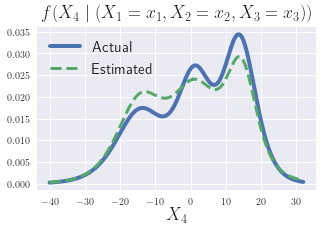

In [48]:
node='D'
i=24


pdf_true, pdf_est, support = plot_true_predicted_pdf(i, node, fig=False)

if node=='A':
    plt.figure(figsize=(5,3))
    plt.plot( support[130:400], pdf_true[130:400], linewidth=4, label='Actual' )
    plt.plot( support[130:400], pdf_est[130:400] , linewidth=3, linestyle='--', label='Estimated' )
    plt.xlabel(r"$X_1$" , fontsize=18)
    plt.title(r"$f(X_1)$" , fontsize=18)
    plt.legend(fontsize=15)
    plt.savefig("fx1.pdf", dpi=300, bbox_inches='tight')
    plt.show()

elif node=='B':
    plt.figure(figsize=(5,3))
    plt.plot( support[130:490], pdf_true[130:490], linewidth=4, label='Actual' )
    plt.plot( support[130:490], pdf_est[130:490] , linewidth=3, linestyle='--', label='Estimated' )
    plt.xlabel(r"$X_2$" , fontsize=18)
    plt.title(r"$f(X_2~|~(X_1=x_1))$" , fontsize=18)
    plt.legend(fontsize=15)
    plt.savefig("fx2.pdf", dpi=300, bbox_inches='tight')
    plt.show()


elif node=='C':
    plt.figure(figsize=(5,3))
    plt.plot( support[0:400], pdf_true[0:400], linewidth=4, label='Actual' )
    plt.plot( support[0:400], pdf_est[0:400] , linewidth=3, linestyle='--', label='Estimated' )
    plt.xlabel(r"$X_3$" , fontsize=18)
    plt.title(r"$f(X_3~|~(X_1=x_1,X_2=x_2))$" , fontsize=18)
    plt.legend(fontsize=15)
    plt.savefig("fx3.pdf", dpi=300, bbox_inches='tight')
    plt.show()

elif node=='D':
    plt.figure(figsize=(5,3))
    plt.plot( support[0:450], pdf_true[0:450], linewidth=4, label='Actual' )
    plt.plot( support[0:450], pdf_est[0:450] , linewidth=3, linestyle='--', label='Estimated' )
    plt.xlabel(r"$X_4$" , fontsize=18)
    plt.title(r"$f(X_4~|~(X_1=x_1,X_2=x_2,X_3=x_3))$" , fontsize=18)
    plt.legend(fontsize=15)
    plt.savefig("fx4.pdf", dpi=300, bbox_inches='tight')
    plt.show()

### Get Estimated Density Parameters of a specific Node (given its parents if any)

In [54]:
node = 'C'
node_parents_data = np.array([[[1,2]]])


node_est_dist_params= bnde.get_node_pdf_params( node, node_parents_data )

## Inference


#### Query on Node B and C
$$P[~(1 \le~B~\le 10) ~\vert~ (-5 \le~A~\le 5)~]$$

In [55]:
query=[ ['B', 1, 10]]
evidence = [['A', -5,5]]

In [56]:
empirical_prob= get_conditional_prob_cont(data_df=data_df ,  query=query , evidence=evidence , verbose=True)
monte_prob= cpquery_approx( query=query , evidence=evidence,  bnde=bnde, n_samples=3000, verbose=True  )

Description of Evidence:
[
(-5 =< A <= 5)
]


Description of Query:
[
(1 =< B <= 10)
]


Description of Query_Evidence_WithoutDeepestNode:
[
(-5 =< A <= 5)
]


Description of Evidence_WithoutDeepestNode:
Evidence is empty. Returning un-conditional data.

]




In [57]:
print("Empirical Probability  =", empirical_prob)
print("MonteCarlo Probability =", monte_prob)

Empirical Probability  = 0.20942582144042482
MonteCarlo Probability = 0.22306147413106003


### Multiple Queries

In [23]:
queries = [ [[ 'D', -20, 15]]  ,
            [['C',-15,5]],
            [[ 'D', -30, 1]  , ['C',-15,0]]  
          ]
 

evidences = [ [[ 'A', -10, 1]]  ,
              [['B',-15,5 ]],
              [[ 'A', -15, 15], ['B',-15,15] ] 
            ]


for query in queries:
    

    for evidence in evidences:
        print('\n\nQuery:\n',query)
        print("\nEvidence:\n",evidence, '\n')
        monte_prob     = cpquery_approx( query , evidence, bnde, n_samples = 1000, verbose=False )
        empirical_prob = get_conditional_prob_cont(test_data_df ,  query , evidence , verbose=False)       
       
        print("Empirical Probability  =", empirical_prob*100, ' %')
        print("MonteCarlo Probability =", monte_prob*100, ' %')
        print("Difference             = {:0.5f} %".format((np.abs(monte_prob-empirical_prob)*100)))
        print('\n\n\n')



Query:
 [['D', -20, 15]]

Evidence:
 [['A', -10, 1]] 

Empirical Probability  = 68.04192685102586  %
MonteCarlo Probability = 70.45279124068573  %
Difference             = 2.41086 %






Query:
 [['D', -20, 15]]

Evidence:
 [['B', -15, 5]] 

Empirical Probability  = 74.71517089746152  %
MonteCarlo Probability = 78.16207135478373  %
Difference             = 3.44690 %






Query:
 [['D', -20, 15]]

Evidence:
 [['A', -15, 15], ['B', -15, 15]] 

Empirical Probability  = 76.9912641315519  %
MonteCarlo Probability = 78.4338932917574  %
Difference             = 1.44263 %






Query:
 [['C', -15, 5]]

Evidence:
 [['A', -10, 1]] 

Empirical Probability  = 56.801962533452276  %
MonteCarlo Probability = 58.158464397354024  %
Difference             = 1.35650 %






Query:
 [['C', -15, 5]]

Evidence:
 [['B', -15, 5]] 

Empirical Probability  = 52.808315010993404  %
MonteCarlo Probability = 53.11241258621264  %
Difference             = 0.30410 %






Query:
 [['C', -15, 5]]

Evidence:
 [['A',

## Total Variation Distance (TVD)
### Calculate TVD between True and Predicted PDFs

In [25]:
# take a batch from test data
num_examples=50
rand_indices = np.random.choice(test_data_df.shape[0] , num_examples)
test_data_df_batch = test_data_df.iloc[rand_indices]


test_true_dist_params = test_dist_params[rand_indices]
test_est_dist_params = bnde.get_prob_density_params( test_data=test_data_df_batch )

In [26]:
## Learn LGM

lgm = learn_LGM(bnde.bayes_net.structure, data_df)




# Save Total-Variation-Distance between True Distribution and Estimated Distribution
TVD_mol   = {'A':[],'B':[],'C':[],'D':[]}
TVD_disc  = {'A':[],'B':[],'C':[],'D':[]}
TVD_lgm   = {'A':[],'B':[],'C':[],'D':[]}



node_support = {}
node_support['A']  = np.linspace(-60,60,500)
node_support['B']  = np.linspace(-60,60,500)
node_support['C']  = np.linspace(-60,60,500)
node_support['D']  = np.linspace(-60,60,500)



for i in range(num_examples):
    
    for node in bnde.nodes:
        
        pa_node = bnde.bayes_net.structure[node]   # parents of node
        pa_node_vals = test_data_df_batch[pa_node].values[i]  # values of parents of node
        
        
        
        _, P_true = convert_logistic_mixture_to_probs(param_matrix=test_true_dist_params[i, node_index[node]] , intervals= node_support[node] )
        
        
        if node in bnde.bayes_net.all_root_nodes:
            # MoL method
            _ , P_mol  = convert_logistic_mixture_to_probs(param_matrix=test_est_dist_params[node] , intervals= node_support[node] )
        
           # Discretization Method
            event_var = node 
            event_var_vals = range(0,len(node_support[node])+1)
            evidence_var = [] 
            evidence_val = []
            P_disc = get_conditional_prob_disc( data_disc_df , event_var, event_var_vals, evidence_var, evidence_val,  verbose=False,  nan2uniform=True)

            # LGM Method
            _ , P_lgm = convert_norm_pdf_to_probs(lgm[node][0], lgm[node][1], intervals=node_support[node])
        
        
        
        else:
            # MoL method
            _ , P_mol  = convert_logistic_mixture_to_probs(param_matrix=test_est_dist_params[node][i] , intervals= node_support[node] )
        
            # Discretization Method
            event_var = node
            event_var_vals = range(0,len(node_support[node])+1)

            evidence_var = pa_node   # evidence nodes contain the parents of selected node
            evidence_val = [ np.digitize(evid_node_val , node_support[evid_node])-1  for evid_node, evid_node_val in  zip(pa_node,pa_node_vals)  ]
            # Continuous value of parent node is converted to corresponding bin index in which it lies
            P_disc = get_conditional_prob_disc( data_disc_df , event_var, event_var_vals, evidence_var, evidence_val,  verbose=False, nan2uniform=True)
        
            # LGM Method
            _, P_lgm  = convert_norm_pdf_to_probs( lgm[node][0].predict(pa_node_vals.reshape(1, -1)), lgm[node][1], intervals= node_support[node]  )
    
  

        TVD_mol[node].append(  TVD(P_true,P_mol)  )
        TVD_disc[node].append( TVD(P_true,P_disc) )
        TVD_lgm[node].append(  TVD(P_true,P_lgm)  )

In [65]:
np.save('TVD_mol.npy' , TVD_mol )  
np.save('TVD_disc.npy', TVD_disc) 
np.save('TVD_lgm.npy' , TVD_lgm ) 

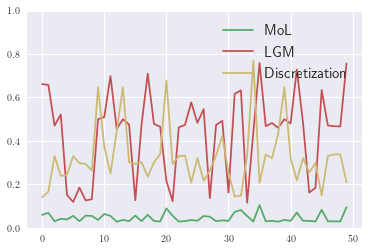

In [59]:
node='B'

plt.plot(TVD_mol[node], color='C1')
plt.plot(TVD_lgm[node], color='C2')
plt.plot(TVD_disc[node], color='C4')
plt.legend(['MoL', 'LGM','Discretization'], fontsize=15)
plt.ylim([0,1])
plt.show()

In [53]:
print( '      MoL                 LGM                Disc'  )
for node in bnde.nodes:
    print( node, '  ',  np.mean(TVD_mol[node]) , np.mean(TVD_lgm[node]), np.mean(TVD_disc[node])    )
    print( node, '  ',  np.std(TVD_mol[node]) , np.std(TVD_lgm[node]), np.std(TVD_disc[node])    , '\n'  )

      MoL                 LGM                Disc
A    0.023361095155613312 0.7107827290480375 0.17065184510030357
A    0.0 1.1102230246251565e-16 2.7755575615628914e-17 

B    0.04658639278742869 0.4376962033478498 0.3245141663546409
B    0.019937488705968634 0.19022895919521166 0.1371396347265625 

C    0.0902211154922784 0.3204667069173493 0.8484609404897314
C    0.04657373123639022 0.1781087500415026 0.1723764633482432 

D    0.1294039327876101 0.32211739280697244 0.6429653748140606
D    0.09194197597984125 0.11896499521539942 0.1842835782251511 



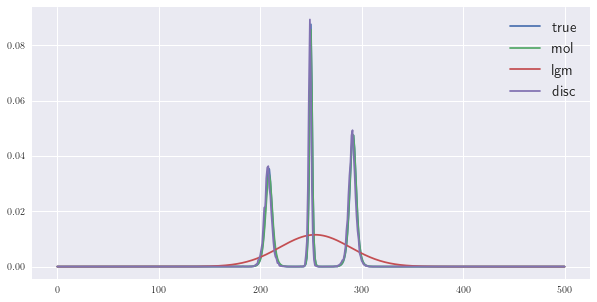

In [52]:
node='A'

pa_node = bnde.bayes_net.structure[node]   # parents of node
pa_node_vals = test_data_df_batch[pa_node].values[i]  # values of parents of node
       

_, P_true = convert_logistic_mixture_to_probs(param_matrix=test_true_dist_params[i, node_index[node]] , intervals= node_support[node] )


_ , P_mol  = convert_logistic_mixture_to_probs(param_matrix=test_est_dist_params[node] , intervals= node_support[node] )

# Discretization Method
event_var = node
event_var_vals = range(0,len(node_support[node])+1)

evidence_var = pa_node   # evidence nodes contain the parents of selected node
evidence_val = [ np.digitize(evid_node_val , node_support[evid_node])-1  for evid_node, evid_node_val in  zip(pa_node,pa_node_vals)  ]
# Continuous value of parent node is converted to corresponding bin index in which it lies
P_disc = get_conditional_prob_disc( data_disc_df , event_var, event_var_vals, evidence_var, evidence_val,  verbose=False, nan2uniform=True)

# LGM Method
_, P_lgm  = convert_norm_pdf_to_probs( lgm[node][0], lgm[node][1], intervals= node_support[node]  )


plt.figure(figsize=(10,5))
plt.plot(P_true)
plt.plot(P_mol)
plt.plot(P_lgm)
plt.plot(P_disc)
plt.legend(['true','mol','lgm','disc'], fontsize=15)

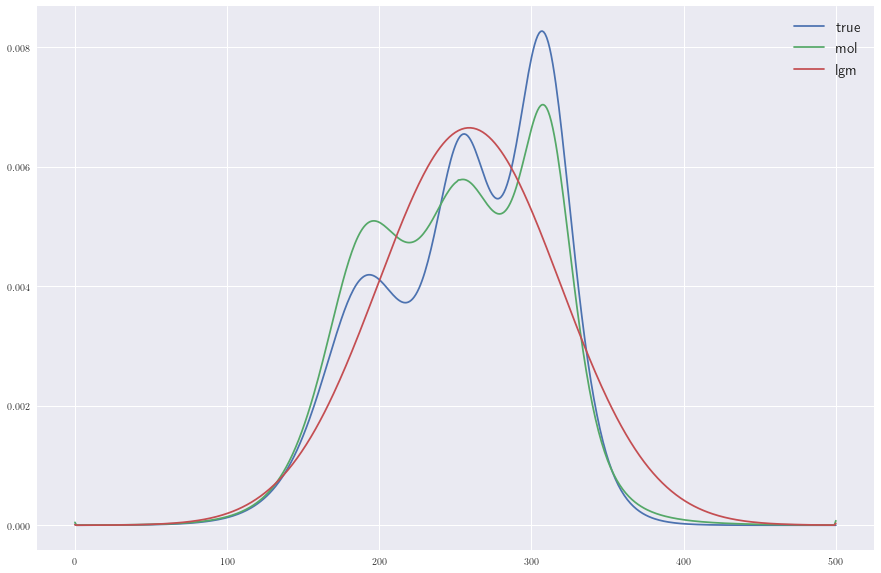

In [51]:
node='D'

pa_node = bnde.bayes_net.structure[node]   # parents of node
pa_node_vals = test_data_df_batch[pa_node].values[i]  # values of parents of node
       

_, P_true = convert_logistic_mixture_to_probs(param_matrix=test_true_dist_params[i, node_index[node]] , intervals= node_support[node] )


_ , P_mol  = convert_logistic_mixture_to_probs(param_matrix=test_est_dist_params[node][i] , intervals= node_support[node] )

# Discretization Method
event_var = node
event_var_vals = range(0,len(node_support[node])+1)

evidence_var = pa_node   # evidence nodes contain the parents of selected node
evidence_val = [ np.digitize(evid_node_val , node_support[evid_node])-1  for evid_node, evid_node_val in  zip(pa_node,pa_node_vals)  ]
# Continuous value of parent node is converted to corresponding bin index in which it lies
P_disc = get_conditional_prob_disc( data_disc_df , event_var, event_var_vals, evidence_var, evidence_val,  verbose=False, nan2uniform=True)

# LGM Method
_, P_lgm  = convert_norm_pdf_to_probs( lgm[node][0].predict(pa_node_vals.reshape(1, -1)), lgm[node][1], intervals= node_support[node]  )


plt.figure(figsize=(15,10))
plt.plot(P_true)
plt.plot(P_mol)
plt.plot(P_lgm)
#plt.plot(P_disc)
plt.legend(['true','mol','lgm','disc'], fontsize=15)

#### Converting Jupyter Notebook to HTML

In [1]:
import os 
cwd = os.getcwd()
os.chdir(cwd)


!jupyter nbconvert BayesianNetworkDensityEstimator_SeparateNetworks.ipynb

[NbConvertApp] Converting notebook BayesianNetworkDensityEstimator_SeparateNetworks.ipynb to html
[NbConvertApp] Writing 596083 bytes to BayesianNetworkDensityEstimator_SeparateNetworks.html
